# 1. 와인 분류하기 2

- 사전 학습 알고리즘으로는 자기부호화기가 유명하다.

### 최적화 기법

1. 가중치 감쇠
2. 배치 정규화

In [1]:
# pyTorch
import torch # tensor
from torch.autograd import Variable # 자동미분
import torch.nn as nn # 신경망구성
import torch.nn.functional as F # 신경망에 사용되는 함수 정의
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# scikit-learn 
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# pandas
import pandas as pd

In [2]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [3]:
wine_data = wine.data[0:130]
wine_target = wine.target[0:130]

In [4]:
wine_data[-3:], wine_target[-3:]

(array([[1.179e+01, 2.130e+00, 2.780e+00, 2.850e+01, 9.200e+01, 2.130e+00,
         2.240e+00, 5.800e-01, 1.760e+00, 3.000e+00, 9.700e-01, 2.440e+00,
         4.660e+02],
        [1.237e+01, 1.630e+00, 2.300e+00, 2.450e+01, 8.800e+01, 2.220e+00,
         2.450e+00, 4.000e-01, 1.900e+00, 2.120e+00, 8.900e-01, 2.780e+00,
         3.420e+02],
        [1.204e+01, 4.300e+00, 2.380e+00, 2.200e+01, 8.000e+01, 2.100e+00,
         1.750e+00, 4.200e-01, 1.350e+00, 2.600e+00, 7.900e-01, 2.570e+00,
         5.800e+02]]), array([1, 1, 1]))

In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(wine_data, wine_target, test_size=0.2)

In [6]:
print(len(train_X), len(test_X))

104 26


## 2. 텐서 생성

In [7]:
# torch.from_numpy(ndarray)
# Numpy 배열을 텐서로 변환한다.

train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

In [8]:
train_X.shape, train_Y.shape

(torch.Size([104, 13]), torch.Size([104]))

In [9]:
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

In [10]:
test_X.shape, test_Y.shape

(torch.Size([26, 13]), torch.Size([26]))

## 3. 설명변수와 목적변수를 합침

In [11]:
# torch.utils.data.TensorDataset(data_tensor, target_tensor)
# 설명변수와 목적변수를 합쳐 인덱스를 붙이고 하나의 데이터 집합으로 만든다.

train = TensorDataset(train_X, train_Y)
print(train[0])

(tensor([ 12.5100,   1.7300,   1.9800,  20.5000,  85.0000,   2.2000,   1.9200,
          0.3200,   1.4800,   2.9400,   1.0400,   3.5700, 672.0000]), tensor(1))


In [12]:
# 데이터 집합을 원하는 크기의 미니배치로 나누어 읽어들인다.
train_loader = DataLoader(train, batch_size=16, shuffle=True)

- dataset(Dataset): 읽어들일 데이터 집합
- batch_size: 배치 크기
- shuffle: 각 에폭마다 데이터 셔플링 여부

## 4. 신경망 구성

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 96)
        self.fc2 = nn.Linear(96, 96)
        self.fc3 = nn.Linear(96, 96)
        self.fc4 = nn.Linear(96, 96)
        self.fc5 = nn.Linear(96, 96)
        self.fc6 = nn.Linear(96, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x)
    
model = Net()

In [18]:
# torch.nn.Module
# 모든 신경망의 갑ㄴ이 된다.

# torch.nn.Linear(in_features, out_features, bias=True)

# torch.nn.functional.relu

## 5. 모형 학습

In [19]:
# 오차 함수 객체
criterion = nn.CrossEntropyLoss()

# 최적화 객체
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 학습 시작
for epoch in range(300):
    total_loss = 0
    
    # 분할해 둔 데이터를 꺼내옴
    for train_x, train_y in train_loader:
        
        # 계산 그래프 구성 
        train_x, train_y = Variable(train_x), Variable(train_y)
        
        # 경사 초기화
        optimizer.zero_grad()
        
        # 순전파 계산
        output = model(train_x)
        
        # 오차 계산
        loss = criterion(output, train_y)
        
        # 역전파 계산
        loss.backward()
        
        # 가중치 업데이트
        optimizer.step()
        
        # 누적 오차 계산
        total_loss += loss.data[0]
        
    if (epoch + 1) % 50 == 0:
        print(epoch + 1, total_loss)

/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50 tensor(2.4700)
100 tensor(1.8214)
150 tensor(1.6348)
200 tensor(1.4889)
250 tensor(1.7697)
300 tensor(1.2800)


# 2. 손글씨 이미지 분류

In [22]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [23]:
from sklearn.datasets import load_digits
from sklearn import datasets, model_selection

In [24]:
import pandas as pd

In [25]:
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

In [27]:
mnist = datasets.fetch_mldata('MNIST original', data_home='./data/')
mnist

/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [28]:
mnist_data = mnist.data / 255
mnist_data.shape

(70000, 784)

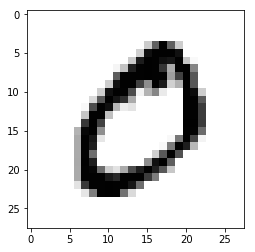

In [29]:
plt.imshow(mnist_data[0].reshape(28, 28), cmap=cm.gray_r)
plt.show()

In [30]:
mnist_label = mnist.target
mnist_label

array([0., 0., 0., ..., 9., 9., 9.])

In [31]:
train_size = 5000
test_size = 500

train_X, test_X, train_Y, test_Y = model_selection.train_test_split(mnist_data, mnist_label, 
                                                                    train_size=train_size,
                                                                    test_size=test_size)

### 텐서 생성

In [32]:
# numpy 배열을 텐서로 변환한다.
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long()

test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).long()

print(train_X.shape)
print(train_Y.shape)

torch.Size([5000, 784])
torch.Size([5000])


In [33]:
# 설명 변수와 목적 변수를 합쳐서 train이라는 이름으로 훈련 데이터 객체를 만든다.
train = TensorDataset(train_X, train_Y)
print(train[0])
train_loader = DataLoader(train, batch_size=100, shuffle=True)

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000,

In [34]:
# torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# 데이터 집합을 원하는 크기의 미니배치로 나누어 읽어 들인다.

### 신경망 구성

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        x = F.dropout(x, training=self.training)
        x = self.fc6(x)
        return F.log_softmax(x)
    
model = Net()

In [43]:
# 오차함수 객체
criterion = nn.CrossEntropyLoss()

# 최적화를 담당할 객체
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1000):
    total_loss = 0
    
    # 분할해 둔 데이터를 꺼내옴
    for train_x, train_y in train_loader:
        
        # compose calculation graph
        train_x, train_y = Variable(train_x), Variable(train_y)
        optimizer.zero_grad()
        
        # forward
        output = model(train_x)
        
        # loss
        loss = criterion(output, train_y)
        
        # backward
        loss.backward()
        
        # update weight
        optimizer.step()
        
        # cumulative loss
        total_loss += loss.data[0]
        
    if (epoch+1)% 100 == 0:
        print(epoch + 1, total_loss)

/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


100 tensor(0.0498)
200 tensor(0.0306)
300 tensor(0.0274)
400 tensor(0.0636)
500 tensor(0.0255)
600 tensor(0.0140)
700 tensor(0.0244)
800 tensor(0.0158)
900 tensor(0.0133)
1000 tensor(0.0250)


In [41]:
# torch.nn.CrossEntropy
# 교차 엔트로피 함수를 구현한 클래스다.

# torch.optim.SGD
# 확률적 경사하강법을 구현한 클래스다.

# torch.autograd.Variable(data)
# 텐서를 래핑하고 계산 과정을 기록한다.

# torch.autograd.backward(variables)
# 경사의 합을 구한다.

In [56]:
# compose calculation graph
test_x, test_y = Variable(test_X), Variable(test_Y)
result = torch.max(model(test_x).data, 1)[1]

/home/lifesailor/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [61]:
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())

In [62]:
accuracy

0.94